# Sentiment Analysis - Movie Reviews
This project was proposed in [Acamica](https://www.acamica.com/) Data Science course. The purpose of the current project is to train and test a Machine Learning model able to classify movie reviews either as *positive* or *negative*.  
The notebook is structured as follows:  
- Data Overview
- Preprocessing
- Modelling
- Testing

## Libraries & Modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import nltk
import joblib
import string
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import load_files
from nltk.tokenize import TweetTokenizer



from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_predict

from sklearn.metrics import classification_report,precision_recall_curve,roc_curve,roc_auc_score,plot_confusion_matrix, accuracy_score

## User Defined Functions

### ROC Curve

In [2]:
def plot_roc_curve(y_train, y_scores, ax = None, label = None):
    if ax is None:
        ax = plt.gca()
    fpr,tpr,thresholds = roc_curve(y_train, y_scores)
    ax.plot(fpr, tpr,linewidth = 2, label = (label))
    ax.plot([0, 1], [0, 1], 'k--', label = 'No-Skill')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive (Recall)')
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.legend(loc = 'lower right')
    ax.set_title(str(label)+str(f' - AUC = {round(roc_auc_score(y_train,y_scores),2)}'))

### Precision-Recall

In [3]:
def plot_precision_recall_curve(y_true, y_scores, label=None, ax = None):
    if ax is None:
        ax = plt.gca()
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    ax.set_title(str(label))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.plot(recalls, precisions,label = label)
    ax.plot([0, 1], [0, 0], 'k--', label = 'No Skill')
    ax.set_xlim([0, 1])
    ax.set_ylim([-0.01, 1])
    ax.legend(loc = 'lower right')

## Data Overview
The data\* is stored in a structured directory, described below.

```
movie_reviews/
  neg/
  pos/
```

Each subdirectory, `neg/` and `pos/`, contains multiple .txt files with reviews. The `load_files` function provided in `scikit-learn` library allows to load the files in the directory and labels the data according to the directory in which the file is stored.

\**The dataset was provided by Acámica.*

In [4]:
moviedir = r'./dataset/movie_reviews' 
movie_reviews = load_files(moviedir, shuffle = True)

The reviews in the `movies_reviews` variable can be accessed using `movie_reviews.data` and the corresponding sentiments using `movie_reviews.target`.

In [5]:
print(f"Dataset has {len(movie_reviews.data)} reviews, labeled as either {movie_reviews.target_names}")

Dataset has 2000 reviews, labeled as either ['neg', 'pos']


Let's check the types of the data.

In [6]:
print('Reviews format: ', type(movie_reviews.data[0]))
print('Target format: ',type(movie_reviews.target[0]))

Reviews format:  <class 'bytes'>
Target format:  <class 'numpy.int64'>


The `movie_reviews.data` correspond to an array of bytes, then this variable will be decoded on purpose of the preprocessing.

As explained above the review and its corresponding sentiment can be accessed using `.data` &amp; `.target` attributes. Find an example below.

In [7]:
print(f'Review\n{movie_reviews.data[0][:500]}\nLabel:{movie_reviews.target[0]}')

Review
b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so cal"
Label:0


The corresponding label to this review is a `0` that is `neg`.

### Balance of the Target variable
An imbalance on the sentiments can introduce bias in the model, let's check the number of records for each sentiment.

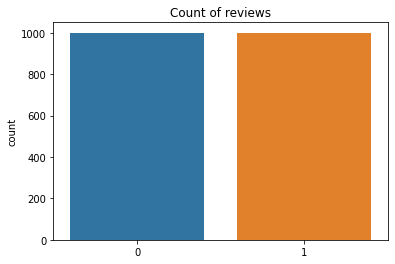

In [8]:
sns.countplot(movie_reviews.target)
plt.title('Count of reviews')
plt.show()

The target variable is balanced, then no actions need to be taken.

## Preprocessing
This phase includes the cleaning and formatting the data before training a model. The computers are not good understanding raw text, then this process converts the text to a vector which is "understadable" by the computer. The following steps will be followed on purpose.

- Lowercasing
- Tokenizing
- Removing stop words and punctuation

The data have been partly normalized at this point. Before we continue preprocessing the data we will build up a *WordCloud\** which will give us an idea of the most common words in the `movie_revies.data`.  

Then, the preprocessing phase will continue with the following steps.

- Stemming
- Vectorizing

\**The WordCloud is not considered as a preprocessing step because it will not change or process the data, it will give us an idea of the most common words in the reviews.*

### Lowercasing
This step reduces the number of unique words because it takes the reviews to its lower case form. Given the same word *Film* we can notice that capitalized and lower case form are two different words, this can be checked with the example below.
```python
print('Film'=='film')
[out]: False
```

In [9]:
movie_reviews.data = [review.strip().lower().decode() for review in movie_reviews.data[0:]]
movie_reviews.data[0][:500]

"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so cal"

### Tokenizing
This step splits the strings into individual words and lowercase them.

In [10]:
tknzr= TweetTokenizer(preserve_case = True, strip_handles = True, reduce_len = True)
movie_reviews.data = [tknzr.tokenize(review) for review in movie_reviews.data[0:]]
movie_reviews.data[0][:10]

['arnold',
 'schwarzenegger',
 'has',
 'been',
 'an',
 'icon',
 'for',
 'action',
 'enthusiasts',
 ',']

### Removing Stop Words &amp; Punctuation
The *Stop Words &amp; Punctuation* do not add valuable information to train a model, then these will be removed from the reviews. Find below the words and characters which will be removed.

In [11]:
stop_words_english = stopwords.words('english') 

print('Stop words\n')
print(stop_words_english)

print('\nPunctuation\n')
print(string.punctuation)

Stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

The words and characters which will be removed.

In [12]:
for i in range(len(movie_reviews.data[:])):
    review = movie_reviews.data[i][:]
    movie_reviews.data[i] = ([str(word) for word in review if (word not in stop_words_english and word not in string.punctuation)])
movie_reviews.data[0][:10]

['arnold',
 'schwarzenegger',
 'icon',
 'action',
 'enthusiasts',
 'since',
 'late',
 '80',
 'lately',
 'films']

### Word Cloud
Let's check the most common words in the reviews graphically using *WordCloud*.

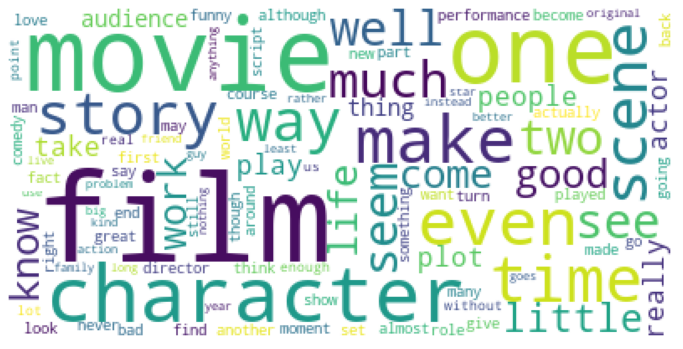

In [13]:
text = ''
for words in movie_reviews.data[:][:]:
    for word in words:
        text += word + ' '
wordcloud = WordCloud(max_words = 100, background_color = 'white').generate(text)
plt.figure(figsize = (12,12))
plt.imshow(wordcloud, interpolation='antialiased', aspect='equal')
plt.axis('off')
plt.show()

### Lemmatizer
Is the process of reducing inflection in words to their root forms, consider the words.

- **teach**
- **teach**ing
- taught

The words will be stemmed to their common root. This is the reason why we have built up the *WordCloud* before this step.

In [14]:
wnl = WordNetLemmatizer()

for i in range(0,len(movie_reviews.data[:])):
    review = movie_reviews.data[i][:]
    movie_reviews.data[i] = [wnl.lemmatize(word) for word in review]
movie_reviews.data[0][:10]

['arnold',
 'schwarzenegger',
 'icon',
 'action',
 'enthusiast',
 'since',
 'late',
 '80',
 'lately',
 'film']

### Vectorizing
Let's reformat the data, the `TfidfVectorizer` receives a list of strings as input.

In [15]:
for i in range(len(movie_reviews.data[:])):
    review = movie_reviews.data[i]
    movie_reviews.data[i] = ' '.join(str(word) for word in review).strip()
movie_reviews.data[0][:500]

"arnold schwarzenegger icon action enthusiast since late 80 lately film sloppy one-liner getting worse hard seeing arnold mr freeze batman robin especially say ton ice joke hey got 15 million what's matter arnold signed another expensive blockbuster can't compare like terminator series true lie even eraser called dark thriller devil gabriel byrne come upon earth impregnate woman robin tunney happens every 1000 year basically destroy world apparently god chosen one man one man jericho cane arnold "

Note that the fucntion `TfidfVectorizer` takes some parameters which corresponds to the ones implemented previously, such as *lowercasing, tokenizing, removing stop words, etc.*
```python
TfidfVectorizer(lowercase=True,
                tokenizer=None,
                stop_words=None,
                ngram_range=(1, 1))
```
Even thought, the implementation of these steps was done with a explanatory purpose. Other parameters can change add other features, such as *ngram_range*, where bigrams, trigrams, etc can be added to the vectorized form of the dataset.

In [16]:
tfidf_vect = TfidfVectorizer(lowercase = True, stop_words = stop_words_english, ngram_range=(1, 1))
movie_reviews.data = tfidf_vect.fit_transform(movie_reviews.data)

## Modelling
This section is composed by rhe following two steps. 

- Train Test Set Split
- Training
    - Naive Bayes
    - Support Vector Machine
    - Logistic Regression
    - Random Forest
- Error Analysis
    - Acurracy
    - Classification Report
    - Confusion Matrix
    - Precision - Recall
    - ROC Curve

### Train Test Set Split
The data will be split into *train &amp; test set* in order to train and evaluate the models stated above.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    movie_reviews.data, movie_reviews.target, test_size = 0.20, stratify = movie_reviews.target, random_state = 0)

The `X_train` &amp; `X_test` variables correspond to a matrix where the rows are reviews and a column for each unique word. That can be compared to the vocabulary in the `TfidfVectorizer`.

In [18]:
print(f'Training set shape: {X_train.shape}\nTraining set shape: {X_test.shape}\nVocabulary length: {len(tfidf_vect.vocabulary_)}')

Training set shape: (1600, 35365)
Training set shape: (400, 35365)
Vocabulary length: 35365


### Training
The following models will be trained 

- Support Vector Machine
- Naive Bayes
- Logistic Regression
- Random Forest

The trained models will be stored in the variable `models` in order to carry out the *Error Analysis*.

In [19]:
models = {}

#### Support Vector Machine
Following the [A Practical Guide to Support Vector Classification](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf) paper, the following model corresponds to a *Support Vector Machine* for Classification.

In [20]:
%%time
clf = LinearSVC(C = 1, loss = 'squared_hinge', random_state = 0)
clf.fit(X_train, y_train)
models[str(type(clf).__name__)] = clf

CPU times: user 200 ms, sys: 0 ns, total: 200 ms
Wall time: 206 ms


#### Naive Bayes

In [21]:
%%time
clf = GaussianNB()
clf.fit(X_train.toarray(), y_train)
models[str(type(clf).__name__)] = clf

CPU times: user 1.29 s, sys: 762 ms, total: 2.06 s
Wall time: 2.09 s


#### Logistic Regression

In [22]:
%%time
clf = LogisticRegression(n_jobs = -1, max_iter = 300,random_state = 0)
clf.fit(X_train, y_train)
models[str(type(clf).__name__)] = clf

CPU times: user 48.4 ms, sys: 124 ms, total: 173 ms
Wall time: 1.91 s


#### Random Forest

In [23]:
%%time
clf = RandomForestClassifier(random_state = 0, bootstrap =  False, criterion = 'entropy', 
                             max_depth = None, min_samples_split = 10, n_estimators = 1000, n_jobs = -1)
clf.fit(X_train, y_train)
models[str(type(clf).__name__)] = clf

CPU times: user 1min 19s, sys: 865 ms, total: 1min 20s
Wall time: 29 s


### Error Analysis
The following metrics will provide us an idea of each model performance which later will help us selecting the one that suits better for the current project.
- Acurracy
- Classification Report
- Confusion Matrix
- Precision - Recall
- ROC Curve

#### Accuracy
This metric is widely used to check the performance of the *Machine Learning* models. However should not be the only one used to evaluate the performance of a model because it can lead to a false sense of security.

In [24]:
for model in models:
    estimator = models[str(model)]
    try:
        y_pred = estimator.predict(X_test)
    except:
        y_pred = estimator.predict(X_test.toarray())
    print(type(estimator).__name__, round(accuracy_score(y_test, y_pred),2))

LinearSVC 0.81
GaussianNB 0.64
LogisticRegression 0.8
RandomForestClassifier 0.82


#### Classification Report
This report provides a high-level overview of the metrics of the model.

In [25]:
for model in models:
    estimator = models[str(model)]
    try:
        y_pred = models[str(model)].predict(X_test)
    except:
        y_pred = models[str(model)].predict(X_test.toarray())
    
    report = classification_report(y_test, y_pred, target_names = movie_reviews.target_names, output_dict = True)
    clsf_report = pd.DataFrame(report).transpose()
    print(f'{model}\n{clsf_report}\n')

LinearSVC
              precision  recall  f1-score   support
neg            0.807882  0.8200  0.813896  200.0000
pos            0.817259  0.8050  0.811083  200.0000
accuracy       0.812500  0.8125  0.812500    0.8125
macro avg      0.812570  0.8125  0.812489  400.0000
weighted avg   0.812570  0.8125  0.812489  400.0000

GaussianNB
              precision  recall  f1-score   support
neg            0.658960  0.5700  0.611260  200.0000
pos            0.621145  0.7050  0.660422  200.0000
accuracy       0.637500  0.6375  0.637500    0.6375
macro avg      0.640052  0.6375  0.635841  400.0000
weighted avg   0.640052  0.6375  0.635841  400.0000

LogisticRegression
              precision  recall  f1-score  support
neg            0.785714   0.825  0.804878    200.0
pos            0.815789   0.775  0.794872    200.0
accuracy       0.800000   0.800  0.800000      0.8
macro avg      0.800752   0.800  0.799875    400.0
weighted avg   0.800752   0.800  0.799875    400.0

RandomForestClassifier
    

#### Confusion Matrix
The confusion matrix provides an overview of the occurrence of accurate predictions and wrong predictions. Metrics such as *precision* &amp; *recall* will be analized further.

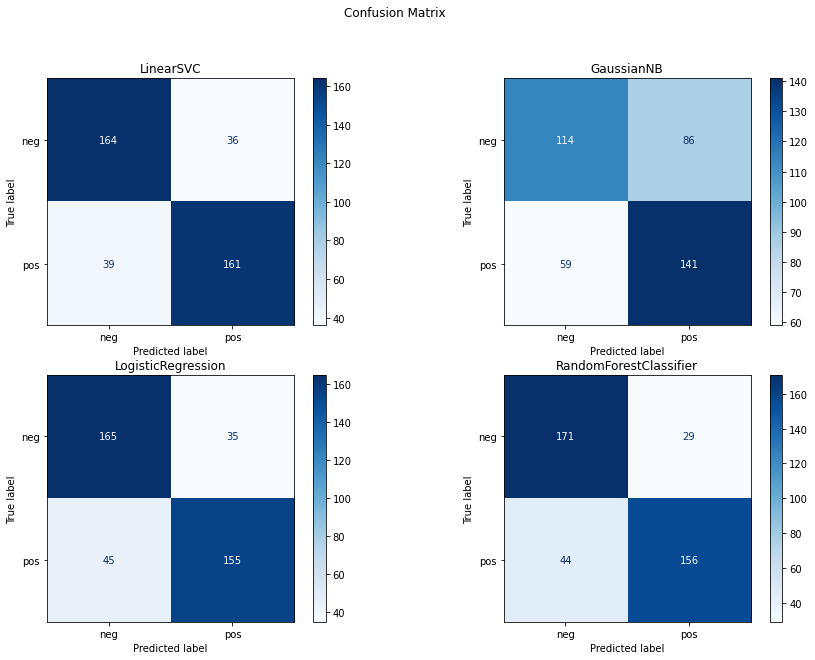

In [26]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
fig.suptitle('Confusion Matrix')

for model, ax in zip(models, axes.flatten()):
    estimator = models[str(model)]
    try:
        plot_confusion_matrix(estimator, X_test, y_test, ax = ax, cmap = 'Blues', 
                              display_labels = movie_reviews.target_names)
    except:
        plot_confusion_matrix(estimator, X_test.toarray(), y_test, ax = ax, cmap = 'Blues', 
                              display_labels = movie_reviews.target_names)
        
    ax.title.set_text(type(estimator).__name__)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
plt.show()

#### Precision - Recall Curve
This graph provides an overview of the precision - recall trade-off, if necessary a threshold can be chosen in order to maximize this one.

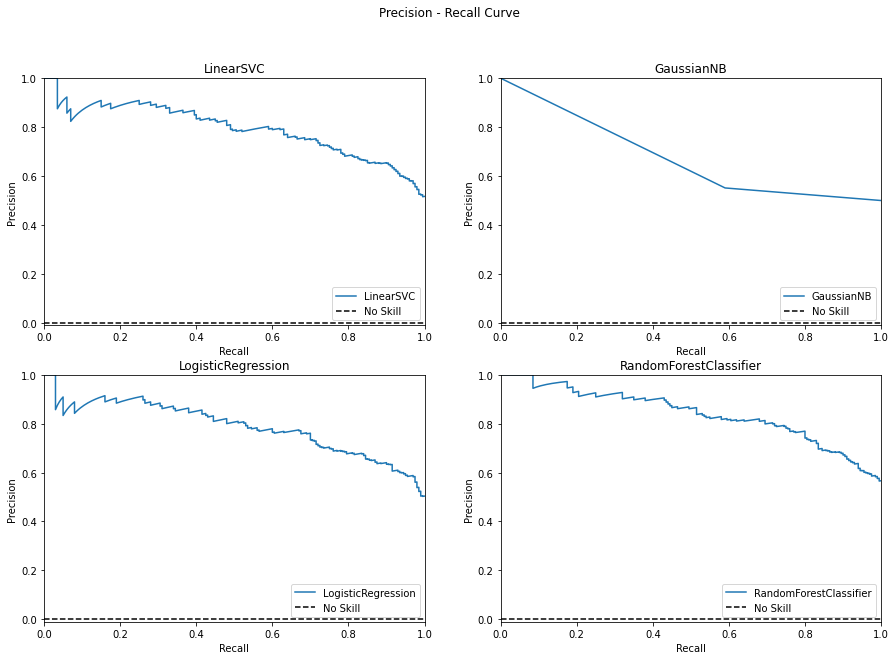

In [27]:
fig,ax = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
fig.suptitle('Precision - Recall Curve')

for model,ax in zip(models, ax.flatten()):
    
    estimator = models[str(model)]
    try:
        y_scores = cross_val_predict(estimator,X_test, y_test, cv = 3, method = 'decision_function')
    except:
        y_scores = cross_val_predict(estimator, X_test.toarray(), y_test,cv = 3,method = 'predict_proba')
        y_scores = y_scores[:,1]
    
    plot_precision_recall_curve(y_test,y_scores,label=str(type(estimator).__name__),ax = ax)
plt.show()

#### ROC Curve
The *Receiving Operating Characteristic Curve* provides an overview of the overall performance of the model. The better performance the more *ROC-Area Under the Curve (AUC)*.

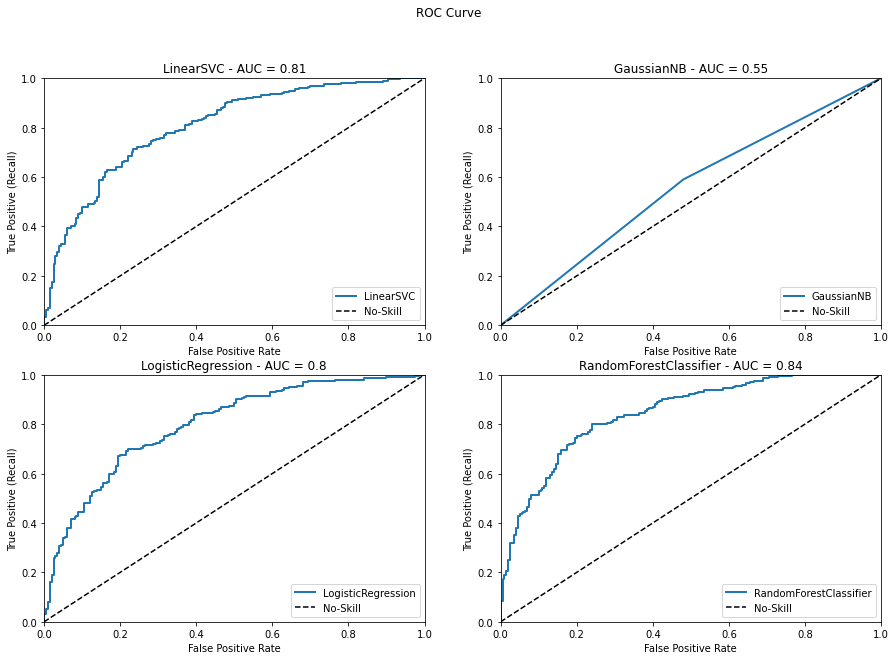

In [28]:
fig,ax = plt.subplots(nrows = 2, ncols = 2,figsize = (15,10))
fig.suptitle('ROC Curve')

for model,ax in zip(models,ax.flatten()):
    
    estimator = models[str(model)]
    try:
        y_scores = cross_val_predict(estimator,X_test, y_test, cv = 3, method = 'decision_function')
    except:
        y_scores = cross_val_predict(estimator, X_test.toarray(), y_test,cv = 3,method = 'predict_proba')
        y_scores = y_scores[:,1]
        
    plot_roc_curve(y_test,y_scores,label=str(type(estimator).__name__),ax = ax)
plt.show()

### Model Selection
The *LinearSVC* showed smaller ROC-AUC &amp; Accuracy compared to RandomForestClassifier, but according to the *classification report* it has a better precision-recall trade-off, both False Positives &amp; False Negatives are balanced.

In [29]:
best_model = models['LinearSVC']
joblib.dump(best_model, 'sentiment.pkl')

['sentiment.pkl']

## Testing

Let's test the chosen model with the [Rocky 4 Reviews - Rotten Tomatoes](https://www.rottentomatoes.com/m/rocky_iv/reviews/?type=user).

In [30]:
reviews_new = ['Highly beautiful',
               "Yeah, this movie sucks.",
               "...suffers from a vibe of superfluousness...",
               "Absurdly ridiculous, this just isn't a good movie at all", 
               "Stallone creates credible villains worthy of his heroic character.",
               "My favourite rocky film! So good so much heart. Slightly better than 2",
               "Another brilliant Rocky film, probably my favourite one out of the lot",
               "Rocky 4 is an extremely ambitious movie that is definitely worth watching.",
               "A far cry from the delights (both large and small) of its illustrious original.",
               "Very basic and predictable but still an okay movie. No special music to save this one.",
               "The new film's narrative is stripped down to essentials, which gives it an emblematic quality.",
               "What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!",
               "While all aspects of realism is thrown out the window, ROCKY IV is an adrenaline rush of action and excitment, with an incredible soundtrack and arguably the best movie fight in history between Balboa and Drago",
               "If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would otherwise be nothing more than an interminable series of mildly rousing montages. There are some unintentionally funny bits though, and Dolph's Ivan showcases the best and worst of all Rocky's opponents.",
               "Just like the songs, exercise routines and repetitive clips, it seems redundant to add another installment in this already falling franchise when you clearly lack material. Rocky IV is petty, childish and seems overlong despite of its 91 minutes of run time for it merely has an idea of a TV drama episode which is stretched to a point of exhaustion. Its painful to watch Sylvester Stallone go through this enormous amount of training and hardly make a point out there. He fails on all the levels here; writer, director and actor, to deliver any loose end of the thread for the audience to hang on to. Rocky IV is predictable, loosely written and choreographed and executed unsupervised."]
reviews_new_counts = tfidf_vect.transform(reviews_new)
reviews_new_tfidf = tfidf_vect.transform(reviews_new)

In [31]:
pred = best_model.predict(reviews_new_tfidf)
for review, category in zip(reviews_new, pred):
    print('%r => %s \n' % (review, movie_reviews.target_names[category]))

'Highly beautiful' => pos 

'Yeah, this movie sucks.' => neg 

'...suffers from a vibe of superfluousness...' => neg 

"Absurdly ridiculous, this just isn't a good movie at all" => neg 

'Stallone creates credible villains worthy of his heroic character.' => pos 

'My favourite rocky film! So good so much heart. Slightly better than 2' => pos 

'Another brilliant Rocky film, probably my favourite one out of the lot' => pos 

'Rocky 4 is an extremely ambitious movie that is definitely worth watching.' => pos 

'A far cry from the delights (both large and small) of its illustrious original.' => pos 

'Very basic and predictable but still an okay movie. No special music to save this one.' => neg 

"The new film's narrative is stripped down to essentials, which gives it an emblematic quality." => neg 

'What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of box